Notebook created by Forrest Hooton

In [7]:
import pandas as pd
import numpy as np
from time import time, sleep
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
mpl.rcParams['figure.dpi']= 150

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

import urllib.request as request
from lxml import etree

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

C:\Users\forresthooton\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [8]:
import sys
sys.path.append('./misc')

import misc.pubmed_util as PMD

# Note: Go directly to "TSNE Vizualizations" section to run plots with TSNE transformation used in paper.

In [9]:
food = 'garlic'
#food = 'cocoa'

food_data = pd.read_pickle('misc_save/' + food + '_food_data.pkl')
foodb_food = pd.read_pickle('misc_save/' + food + '_foodb_food.pkl')
usda = pd.read_pickle('misc_save/' + food + '_usda_conv.pkl')

foodb_food = foodb_food[foodb_food.standard_content.notnull()]

u = ['mg/100g', 'mg/100']
foodb_food = foodb_food[foodb_food.units.isin(u)]

foodb_food = foodb_food.rename(columns={'orig_source_name' : 'chemical', 'standard_content':'average_mean'})
usda = usda.rename(columns = {'nut_desc' : 'chemical', 'usda_amount' : 'average_mean'})

food_data['source'] = 'pilot'
foodb_food['source'] = 'FooDB'
usda['source'] = 'USDA'

In [10]:
def filt(df, simple=False):
    
    if simple:
        df = df[['chemical', 'chem_id_p']].drop_duplicates()
    else:
        df = df[['chemical', 'chem_id_p', 'average_mean', 'source']].drop_duplicates()
    
    df = df[df['chem_id_p'].notnull()]
    
    return df.reset_index(drop=True)

chems = pd.concat([filt(food_data, simple=True), 
                   filt(foodb_food, simple=True),
                   filt(usda, simple=True)])

In [26]:
for idx, row in chems.iterrows():
    chems.at[idx, 'SMILE'] = PMD.pubchem_SMILE(str(int(row['chem_id_p'])))
    sleep(.1)

In [5]:
#chems.to_pickle('misc_save/' + food + '_SMILES.pkl')
chems = pd.read_pickle('misc_save/' + food + '_SMILES.pkl')

# Fingerprint Analysis

In [9]:
def get_ordered_fingerprint_string(SMILE):
    # Obtain dictionary of fingerprints and order
    bi = {}
    AllChem.GetMorganFingerprint(Chem.MolFromSmiles(SMILE), radius=1, bitInfo=bi)

    # Iterate over dictionary to store as pd.Series
    mol = pd.DataFrame()
    for key, value in bi.items():
        for i in range(len(value)):
            sub = pd.Series()
            sub['val'] = str(key)

            sub['order'] = value[i][0]
            sub['radius'] = value[i][1]

            mol = mol.append(sub, ignore_index=True)

    # Correctly order fingerprint
    mol = mol.sort_values(by=['order', 'radius']).reset_index(drop=True)

    # Convert ordered fingerprint into single string
    mol_string = " ".join(mol.val.tolist())
        
    return mol_string.strip()

for idx, row in chems.iterrows():
    chems.at[idx, 'fingerprint'] = get_ordered_fingerprint_string(row['SMILE'])

In [11]:
#chems.to_pickle('misc_save/' + food + '_fingerprints.pkl')
chems = pd.read_pickle('misc_save/' + food + '_fingerprints.pkl')

In [12]:
from collections import Counter
import re

# Extract all fingerprints
fingerprints = [f.split() for f in chems.fingerprint.tolist()]

# Combine all subcomponents into flattened list
f_flattened = [c for f in fingerprints for c in f]

# Count all subcomponents
f_counts = Counter(f_flattened)

# Make a list of subcomponents with 3 or fewer occurences
unks = []
for key, value in f_counts.items():
    if value <= 3:
        unks.append(re.escape(key))

# Create regex to filter out unknowns
unk_regex = '(' + ')|('.join(unks) + ')'

# Replace all subcomponents with 3 or fewer occurances by 'UNK'
for idx, row in chems.iterrows():
    chems.at[idx, 'fingerprint'] = re.sub(unk_regex, 'UNK', row['fingerprint'])

In [13]:
# Create word embedding model for subcomponents
fingerprints = [f.split() for f in chems.fingerprint.tolist()]

dim_embedding = 100

model = Word2Vec(fingerprints, size=dim_embedding, sg=1, window=5, min_count=1, workers=4)
model.train(fingerprints, total_examples=model.corpus_count, epochs=model.epochs)

(21092, 49290)

In [14]:
def calc_fingerprint_vector(model, fingerprint):
    fingerprints = fingerprint.split()
    
    # Extract substructure embeddigns
    fingerprint_substructures = [model.wv[f] for f in fingerprints]
    
    # Sum substructure embeddings to create molecule vector
    fingerprint_vector = np.sum(fingerprint_substructures, axis=0)
    
    # Store fingerprint vector as string
    fingerprint_vector = ' '.join([str(i) for i in fingerprint_vector])
    
    return fingerprint_vector
    
for idx, row in chems.iterrows():
    chems.at[idx, 'fingerprint_vector'] = calc_fingerprint_vector(model, row['fingerprint'])
    

# Dimensinality Reduction and Visualization

In [18]:
# Consolidates matching chemicals in that appear in multiple databases
def clean_source(data):
    consolidated_data = pd.DataFrame()
    for ID in data.chem_id_p.drop_duplicates().tolist():
        temp = data[data.chem_id_p == ID].copy().reset_index(drop=True)

        if len(temp) > 1:

            if len(set(temp.source.tolist())) == 1:
                sources = temp.source.tolist()[0]
            else:
                sources = "-".join(list(set(temp.source.tolist())))

            new_row = pd.Series()
            new_row['chemical'] = temp.loc[0, 'chemical']
            new_row['chem_id_p'] = temp.loc[0, 'chem_id_p']
            new_row['SMILE'] = temp.loc[0, 'SMILE']
            new_row['fingerprint'] = temp.loc[0, 'fingerprint']
            new_row['fingerprint_vector'] = temp.loc[0, 'fingerprint_vector']
            new_row['average_mean'] = temp.average_mean.mean()
            new_row['source'] = sources

            consolidated_data = consolidated_data.append(new_row, ignore_index=True)

        else:
            consolidated_data = consolidated_data.append(temp, ignore_index=True)
            
    return consolidated_data

In [16]:
# Read in CTD data
skip = list(range(26)) # First few lines are empty / not useful info
hdata = pd.read_csv('data/CTD_chemicals_diseases.csv', skiprows=skip).reset_index()
hdata.columns = ['ChemicalName', 'ChemicalID', 'CasRN', 'DiseaseName', 'DiseaseID', 'DirectEvidence', 'InferenceGeneSymbol', 'InferenceScore', 'OmimIDs', 'PubMedIDs']
hdata = hdata.drop([0,1], axis = 0).reset_index(drop=True)

# Pubchem ids of all chemicals in CTD
health_pubchem_ids = pd.read_pickle('misc_save/health_chem_pubchem_ids.pickle').drop('pubchem_name', axis=1)

hdata = hdata.merge(health_pubchem_ids, how='left', on='ChemicalName')

# Count the number of 'Direct Evidence' listings per chemical with a pubchem id
de_health = pd.DataFrame(
    hdata[hdata.pubchem_id.notnull() & hdata.DirectEvidence.notnull()][['pubchem_id', 'DirectEvidence', 'ChemicalName']]
    .groupby(['pubchem_id','DirectEvidence']).count()).reset_index()

# The 'ChemicalName' now holds the count of 'Direct Evidence' listings
health = de_health[['pubchem_id', 'ChemicalName']].groupby('pubchem_id').sum()

C:\Users\forresthooton\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
food_mine = pd.read_pickle('misc_save/' + food + '_quant_fm.pkl')
food_mine['source'] = 'Pilot'

# Combine data sources and add fingerprints to compounds
data = pd.concat([filt(food_mine), filt(foodb_food), filt(usda)])
data = data.merge(chems.drop(columns='chemical'), how='left', on = 'chem_id_p')

# Clean sources and combine them
data = clean_source(data)

# Add CTD data
data = data.merge(health, how='left', left_on = 'chem_id_p', right_on = 'pubchem_id')

data.ChemicalName = data.ChemicalName.fillna(0)

# Extract list of fingerprint vectors for TSNE
dr_data = [v.split() for v in data.fingerprint_vector.tolist()]

C:\Users\forresthooton\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [31]:
dr_data = [[float(i) for i in j] for j in dr_data]

In [28]:
tsne = TSNE(n_components=2)
tsne_fit = tsne.fit_transform(dr_data)

In [29]:
# Prep data for vizualization
viz_data = pd.DataFrame(tsne_fit, columns = ['tsne_0', 'tsne_1'])
viz_data['source'] = data.source.tolist()
viz_data['chemical'] = data.chemical.tolist()
viz_data.tsne_1 = viz_data.tsne_1 * -1
viz_data['mg/100g'] = data.average_mean.tolist()
viz_data['Number of Health Associations'] = data.ChemicalName.fillna(0).tolist()

# TSNE Vizualizations

In [26]:
target_col = 'mg/100g'
food = 'garlic'

# Loads specific TSNE transformation used in paper plots
viz_data = pd.read_pickle(f'misc_save/tsne_{food}_vizdata.pkl')
viz_data = viz_data[['tsne_0', 'tsne_1', 'source', 'chemical', target_col]]
viz_data.head()

[Text(1, 0, '5e-05'),
 Text(1, 0, '0.007'),
 Text(1, 0, '1e+00'),
 Text(1, 0, '1e+02'),
 Text(1, 0, '2e+04')]

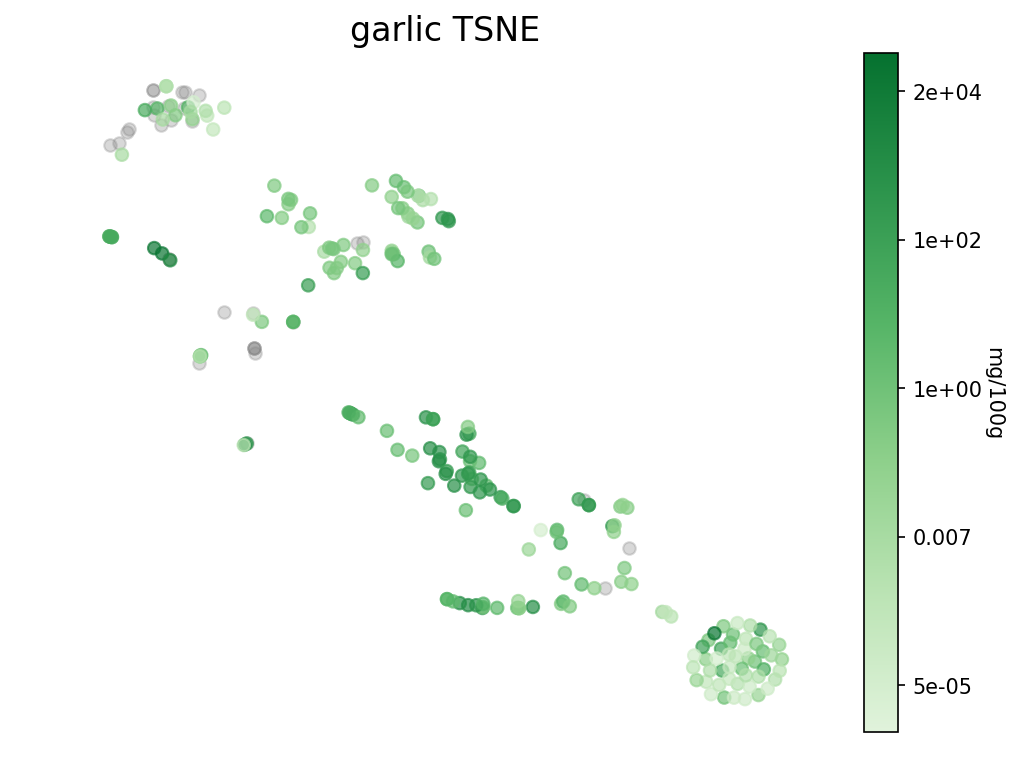

In [30]:
from matplotlib.colors import ListedColormap
import matplotlib.colors as clr

_, ax = plt.subplots(figsize=(8,6))

# Seperate 0 and non-zero data
v1 = viz_data[viz_data[target_col] != 0]
v2 = viz_data[viz_data[target_col] == 0]

color_values = v1[target_col].apply(np.log).tolist()

min_c_val = -11.6 # Need to hardcode to make colorbars same for cocoa and garlic
max_c_val = 11.3

levels = np.linspace(min_c_val, max_c_val, 10)

# Plot data with 0 in grey
ax.scatter(v2.tsne_0.tolist(), v2.tsne_1.tolist(), c='grey',
           marker='o', alpha=.3)

# Plot non-zero data accoring to color bar
f = ax.scatter(v1.tsne_0.tolist(), v1.tsne_1.tolist(), c=color_values,
           cmap=clr.LinearSegmentedColormap.from_list('map1', sns.color_palette("Greens").as_hex(), N = 10000),
               marker='o', alpha=.7, vmin=min_c_val, vmax=max_c_val)

ax.set_title(food + ' TSNE', fontsize=16)
plt.axis('off')

cbar = plt.colorbar(f)
cbar.set_label(target_col, rotation=270, labelpad=+10)

ticks = cbar.get_ticks()
cbar.ax.set_yticklabels(["{:.1}".format(np.exp(t)) for t in ticks])

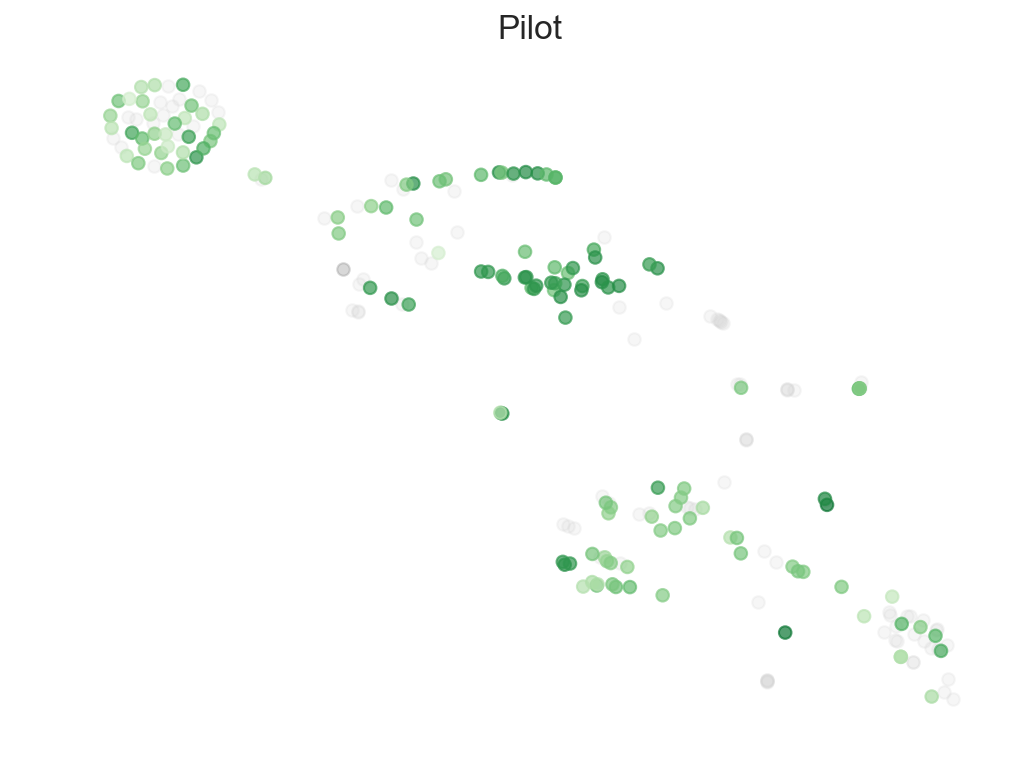

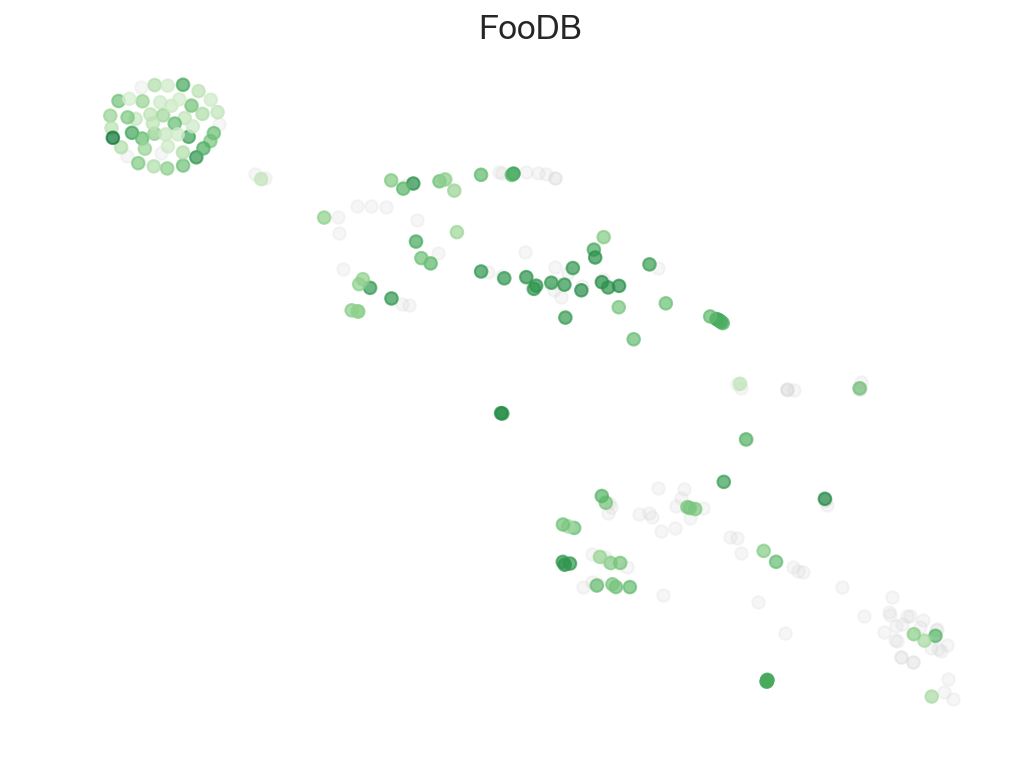

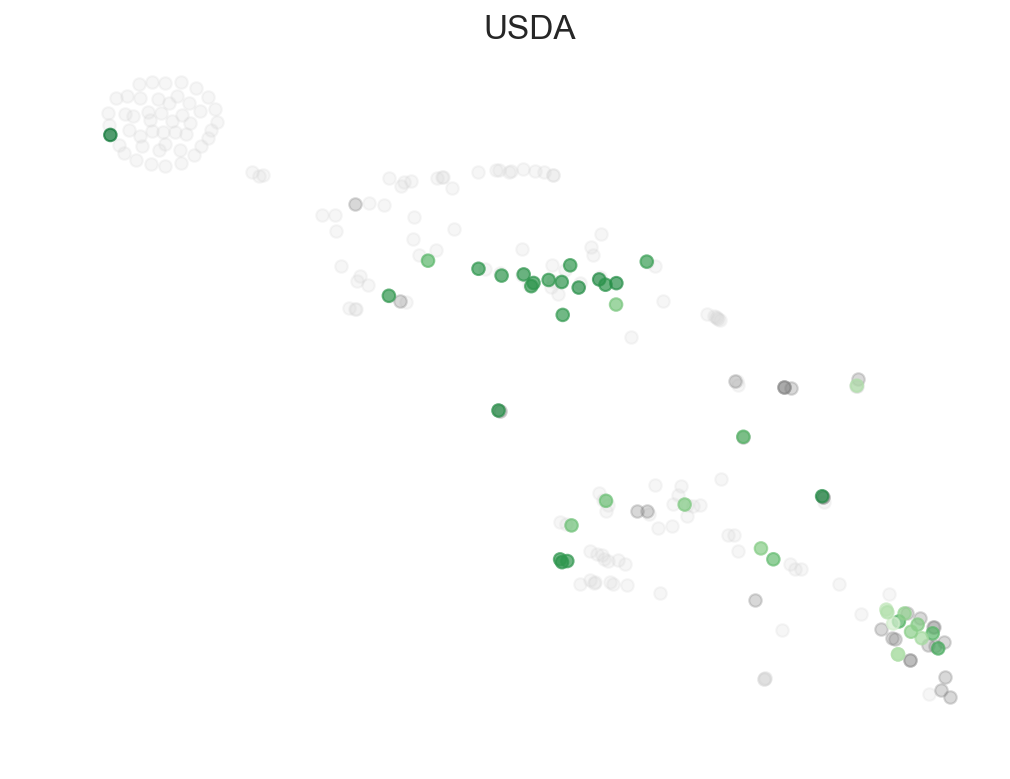

In [115]:
from matplotlib.colors import ListedColormap
import matplotlib.colors as clr

source_strings = ['Pilot', 'FooDB', 'USDA']

main_color = 'Greens'

color_pals = {
    'Pilot' : clr.LinearSegmentedColormap.from_list('map1', sns.color_palette(main_color).as_hex()),
    'FooDB' : clr.LinearSegmentedColormap.from_list('map2', sns.color_palette(main_color).as_hex()),
    'USDA' : clr.LinearSegmentedColormap.from_list('map3', sns.color_palette(main_color).as_hex())
}

# Plot each datasource as seperate graph
for s in source_strings:
    # Seperate values in datasource from values not in datasource
    temp = viz_data[viz_data.source.str.contains(s)]
    antitemp = viz_data[~viz_data.source.str.contains(s)]
    
    with sns.axes_style('white'):
        _, ax = plt.subplots(figsize=(8,6))

        color_values = temp[target_col].apply(np.log).tolist()
        
        # Plot values not in datasource as lightgrey
        ax.scatter(antitemp.tsne_0.tolist(), antitemp.tsne_1.tolist(), c='lightgrey',
                   marker='o', alpha=.2)

        v1 = temp[temp[target_col] != 0]
        v2 = temp[temp[target_col] == 0]

        color_values = v1[target_col].apply(np.log).tolist()

        # Plot values in datasource with a value of 0 as grey
        ax.scatter(v2.tsne_0.tolist(), v2.tsne_1.tolist(), c='grey',
                   marker='o', alpha=.3)

        # Plot values in datasource with a nonzero value in the colormap color
        f = ax.scatter(v1.tsne_0.tolist(), v1.tsne_1.tolist(), c=color_values,
                   cmap=color_pals[s], marker='o', alpha=.7, vmin=min_c_val, vmax=max_c_val)

        ax.set_title(s, fontsize=16)
        plt.axis('off')

        plt.show()

In [116]:
target_col = 'Number of Health Associations'
food = 'garlic'

# Loads specific TSNE transformation used in paper plots
viz_data = pd.read_pickle(f'misc_save/tsne_{food}_vizdata.pkl')
viz_data = viz_data[['tsne_0', 'tsne_1', 'source', 'chemical', target_col]]
viz_data.head()

,tsne_0,tsne_1,source,chemical,Number of Health Associations
0,-3.501258,7.667711,Pilot,allyl methyl sulfide,0.0
1,-4.504283,7.497320,FooDB-Pilot,dimethyl disulfide,0.0
2,-1.860693,7.946868,Pilot,diallyl sulfide,15.0
3,-2.414430,7.849219,FooDB-Pilot,allyl methyl disulfide,1.0
4,-3.695643,7.588176,FooDB-Pilot,dimethyl trisulfide,0.0


[Text(1, 0, '1'),
 Text(1, 0, '3'),
 Text(1, 0, '7'),
 Text(1, 0, '20'),
 Text(1, 0, '55'),
 Text(1, 0, '148')]

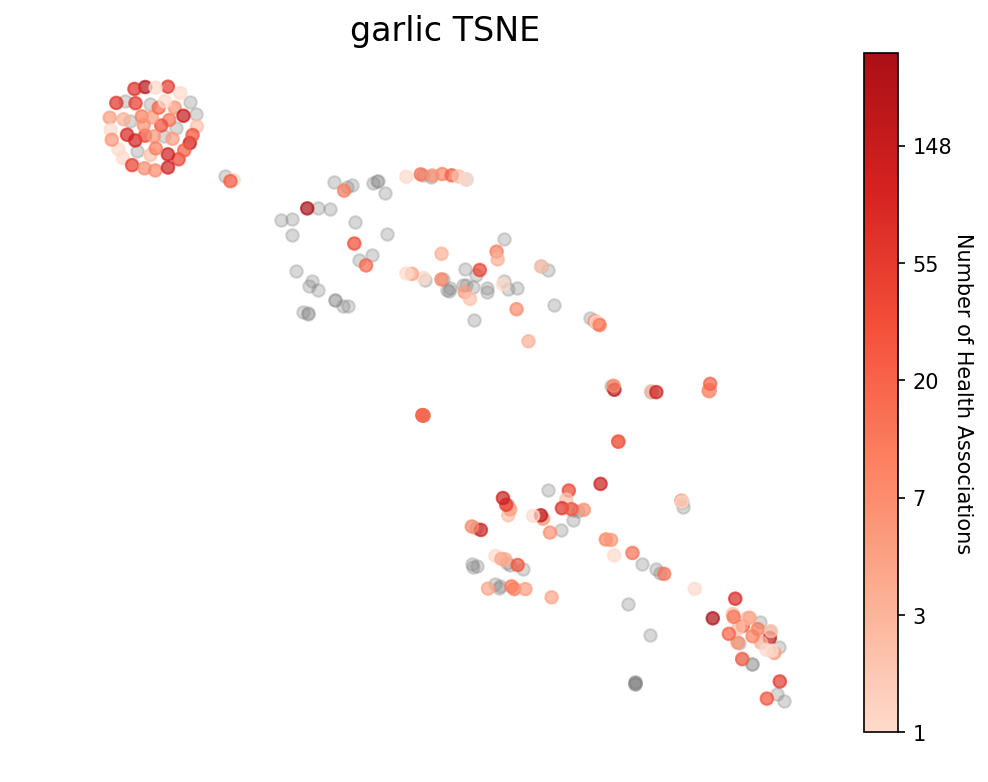

In [117]:
from matplotlib.colors import ListedColormap
import matplotlib.colors as clr

_, ax = plt.subplots(figsize=(8,6))

# Seperate 0 and non-zero data
v1 = viz_data[viz_data[target_col] != 0]
v2 = viz_data[viz_data[target_col] == 0]

color_values = v1[target_col].apply(np.log).tolist()

min_c_val = min(color_values)
max_c_val = max(color_values)

levels = np.linspace(min_c_val, max_c_val, 10)

# Plot data with 0 in grey
ax.scatter(v2.tsne_0.tolist(), v2.tsne_1.tolist(), c='grey',
           marker='o', alpha=.3)

# Plot non-zero data accoring to color bar
f = ax.scatter(v1.tsne_0.tolist(), v1.tsne_1.tolist(), c=color_values,
           cmap=clr.LinearSegmentedColormap.from_list('map1', sns.color_palette("Reds").as_hex(), N = 10000),
               marker='o', alpha=.7, vmin=min_c_val, vmax=max_c_val)

ax.set_title(food + ' TSNE', fontsize=16)
plt.axis('off')

cbar = plt.colorbar(f)
cbar.set_label(target_col, rotation=270, labelpad=+10)

ticks = cbar.get_ticks()
cbar.ax.set_yticklabels([int(round(np.exp(t))) for t in ticks])

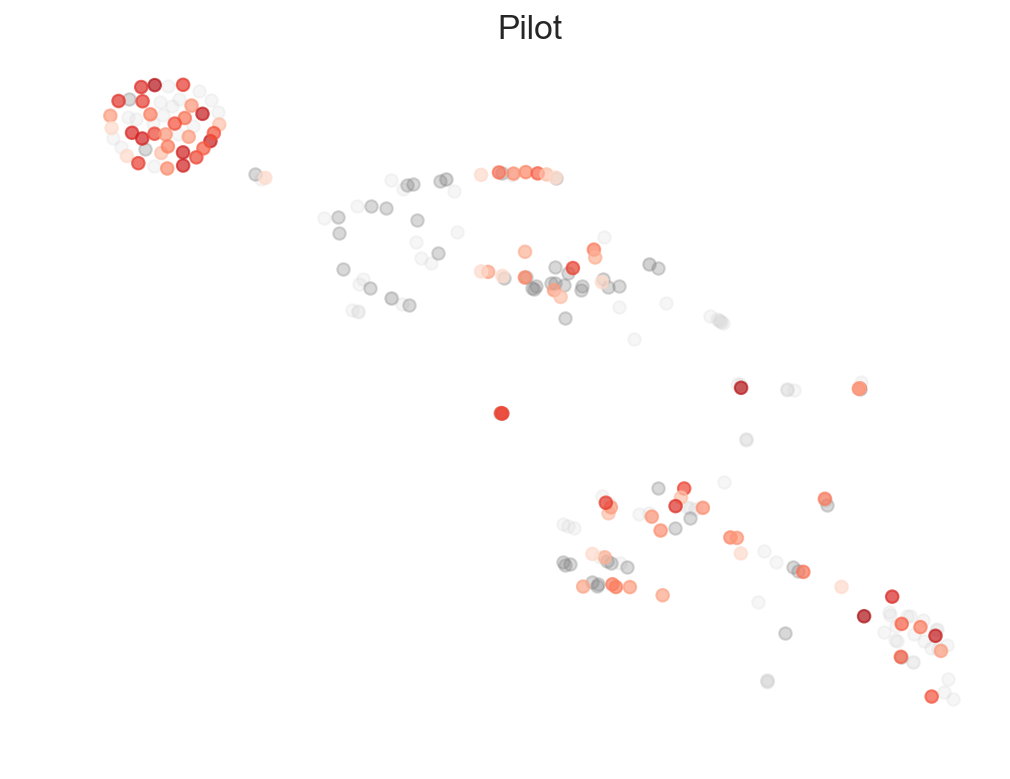

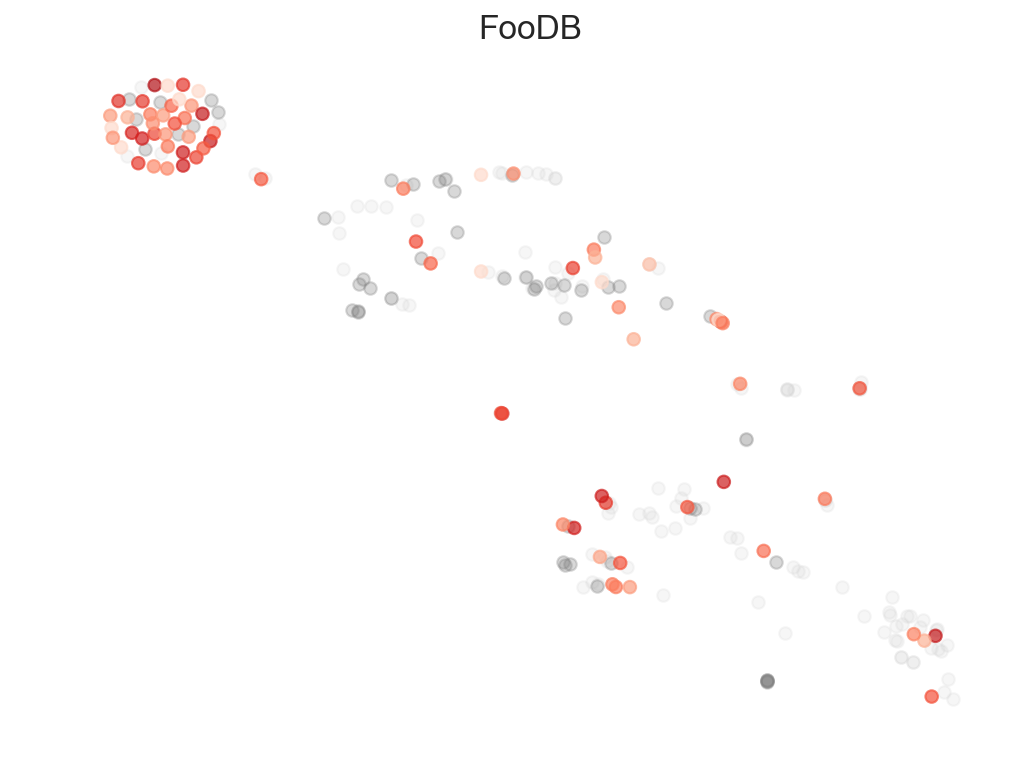

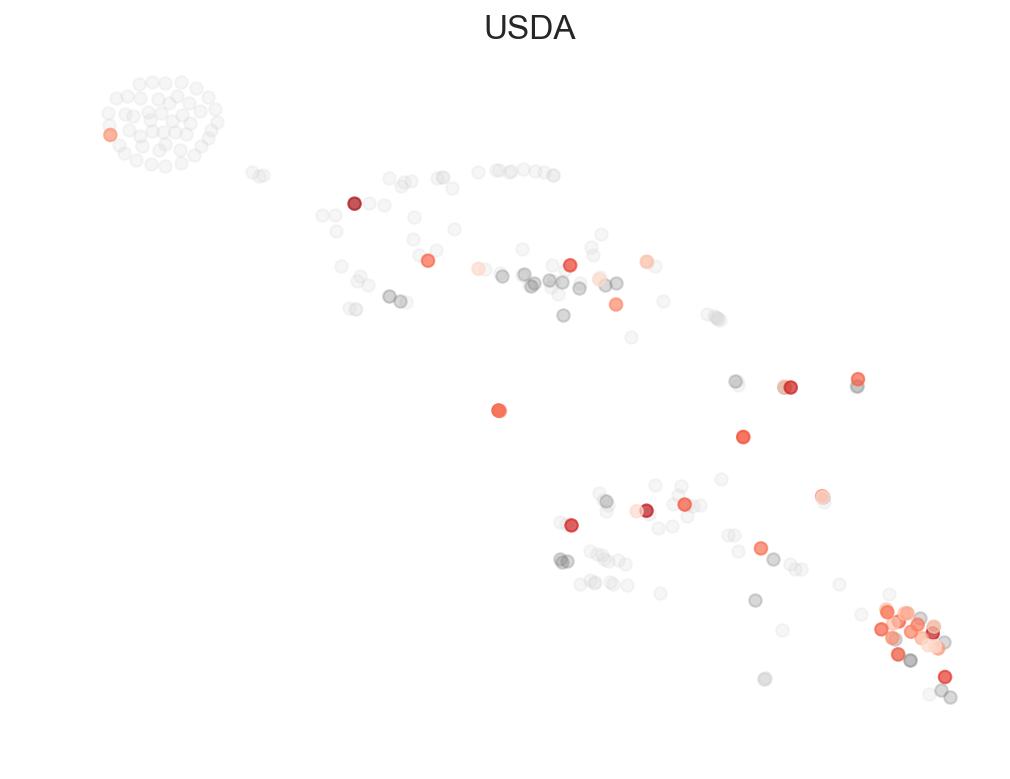

In [119]:
from matplotlib.colors import ListedColormap
import matplotlib.colors as clr

source_strings = ['Pilot', 'FooDB', 'USDA']

main_color = 'Reds'
color_pals = {
    'Pilot' : clr.LinearSegmentedColormap.from_list('map1', sns.color_palette(main_color).as_hex()),
    'FooDB' : clr.LinearSegmentedColormap.from_list('map2', sns.color_palette(main_color).as_hex()),
    'USDA' : clr.LinearSegmentedColormap.from_list('map3', sns.color_palette(main_color).as_hex())
}

# Plot each datasource as seperate graph
for s in source_strings:
    # Seperate values in datasource from values not in datasource
    temp = viz_data[viz_data.source.str.contains(s)]
    antitemp = viz_data[~viz_data.source.str.contains(s)]
    
    with sns.axes_style('white'):
        _, ax = plt.subplots(figsize=(8,6))

        color_values = temp[target_col].apply(np.log).tolist()
        
        # Plot values not in datasource as lightgrey
        ax.scatter(antitemp.tsne_0.tolist(), antitemp.tsne_1.tolist(), c='lightgrey',
                   marker='o', alpha=.2)

        v1 = temp[temp[target_col] != 0]
        v2 = temp[temp[target_col] == 0]

        color_values = v1[target_col].apply(np.log).tolist()

        # Plot values in datasource with a value of 0 as grey
        ax.scatter(v2.tsne_0.tolist(), v2.tsne_1.tolist(), c='grey',
                   marker='o', alpha=.3)

        # Plot values in datasource with a nonzero value in the colormap color
        f = ax.scatter(v1.tsne_0.tolist(), v1.tsne_1.tolist(), c=color_values,
                   cmap=color_pals[s], marker='o', alpha=.7, vmin=min_c_val, vmax=max_c_val)

        ax.set_title(s, fontsize=16)
        plt.axis('off')

        plt.show()